<center>
    <h1><font color=darkred> Tsinghua University </font></h1>
    <h1><font color=darkred> Department of Industrial Engineering </font></h1>
    <h3> Machine Learning and Big-data (30160253) </h3>
    <h4> Fall 2024 </h4>
    <hr>
    <h1> Homework 3: Feature Engineering and Model Training </h1>
    <h3></h3>
</center>

### 1. Problem

1) Use linear regression models with regularization terms to predict the sales volume of air conditioning.

2) Adopt appropriate feature engineering methods to process features.

3) Use cross-validation method for hyper-parameter tuning, i.e. adjusting $\lambda$ of the regularization term.

4) Draw a residual plot and print MSE and R-squared metrics to measure the performance of the model on the test set.


### 2. Data processing

In [208]:
import pandas as pd

data = pd.read_csv('Air_conditioning.csv')
data.head()  # Display the first 5 rows of data

,Air Temperature,Price,Cost,Profit,Sales Promotion,House Sales Volume,Search Volume on E-commerce,Changes in Brand Reputation,Number of Advertisements,Region,Sales Volume
0,27.5,2185.0,1217.0,968.0,Yes,1050,7.41,0.48,0.93,South,389.0
1,39.0,2542.0,1434.0,1108.0,Yes,1040,11.20,1.41,1.53,North,290.0
2,34.6,2873.0,1662.0,1211.0,No,1016,36.77,1.58,0.71,West,185.0
3,32.0,2732.0,1608.0,1124.0,No,1072,5.57,0.68,0.08,North,185.0
4,23.1,2807.0,1680.0,1127.0,Yes,1007,8.50,5.94,0.19,South,322.0


In [209]:
# Split the training set and test set
train_data = data.iloc[:800,:]
test_data = data.iloc[800:,:]
X_train = train_data.drop('Sales Volume', axis=1)
y_train = train_data['Sales Volume']
X_test = test_data.drop('Sales Volume',axis=1)
y_test = test_data['Sales Volume']

### 3. Feature Engineering

In [210]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder,PowerTransformer,FunctionTransformer
from sklearn.compose import ColumnTransformer
import numpy as np
def selection(X_tmp):
    X_new=X_tmp.drop(['Cost','Profit'],axis = 1)
    return X_new

X_train = X_train.drop(['Cost','Profit'],axis = 1)
X_test = X_test.drop(['Cost','Profit'],axis = 1)

categorical_transformer = OneHotEncoder( sparse_output=False ) #drop='first' 
standard_transformer = StandardScaler()
power_transformer = PowerTransformer(method='box-cox')
#delete_transformer = FunctionTransformer(func=selection)

categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]
standard_cols = ['Air Temperature','Price','House Sales Volume']
power_cols = ['Search Volume on E-commerce','Changes in Brand Reputation','Number of Advertisements']
#del_cols = ['Cost','Profit']

preprocessor = ColumnTransformer(
    transformers=[
        ('std', standard_transformer, standard_cols),
        ('pow',power_transformer,power_cols),
        ('cat', categorical_transformer, categorical_cols),
        #('del',delete_transformer,del_cols),
        ]
    )
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=preprocessor.get_feature_names_out())

### 4. Model Training and Prediction

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


Text(0.5, 0, 'Real Value')

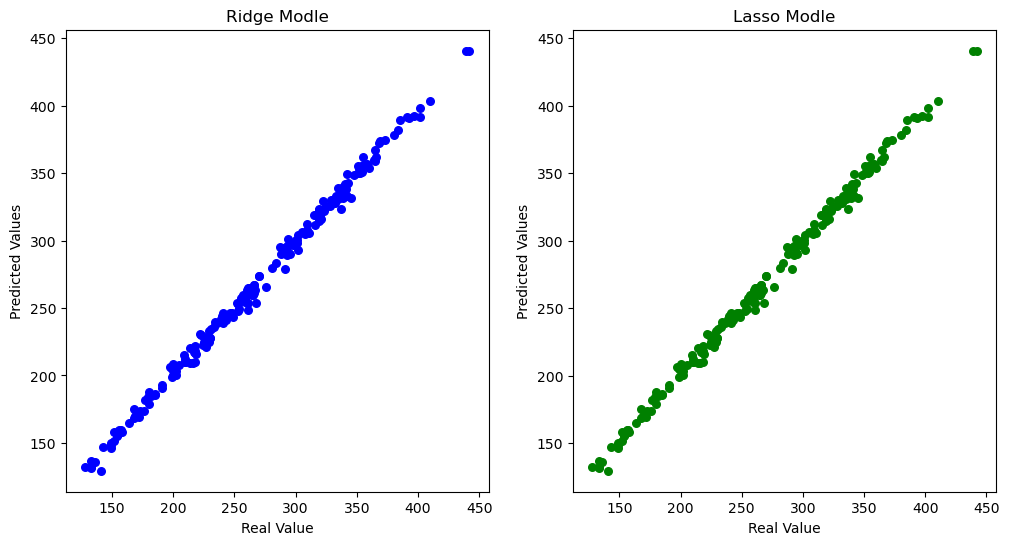

In [211]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

ridge_pipeline = Pipeline(steps=[('model', Ridge())])
lasso_pipeline = Pipeline(steps=[('model', Lasso())])
param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

ridge_grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
ridge_grid_search.fit(X_train_transformed_df, y_train)
lasso_grid_search = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
lasso_grid_search.fit(X_train_transformed_df, y_train)

best_ridge_estimator = ridge_grid_search.best_estimator_
best_lasso_estimator = lasso_grid_search.best_estimator_

ridge_pred = best_ridge_estimator.predict(X_test_transformed_df)
lasso_pred = best_lasso_estimator.predict(X_test_transformed_df)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, ridge_pred, color='blue', s=30)
plt.title('Ridge Modle')
plt.ylabel('Predicted Values')
plt.xlabel('Real Value')

plt.subplot(1, 2, 2)
plt.scatter(y_test, lasso_pred, color='green', s=30)
plt.title('Lasso Modle')
plt.ylabel('Predicted Values')
plt.xlabel('Real Value')


### 5. Permance metrics

In [212]:
# Calculating MSE and R-squared for both models
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

print(f"Ridge Model:MSE={ridge_mse},r2={ridge_r2},and {ridge_grid_search.best_params_}")
print(f"Lasso Model:MSE={lasso_mse},r2={lasso_r2},and {lasso_grid_search.best_params_}")

Ridge Model:MSE=19.175425257680505,r2=0.9963104740523597,and {'model__alpha': 0.1}
Lasso Model:MSE=19.180400381408916,r2=0.9963095167933763,and {'model__alpha': 0.01}


比较MSE和r2发现均是RidgeModel更优，因此选择Ridge正则化模型，且对应最优的正则化强度参数为0.1

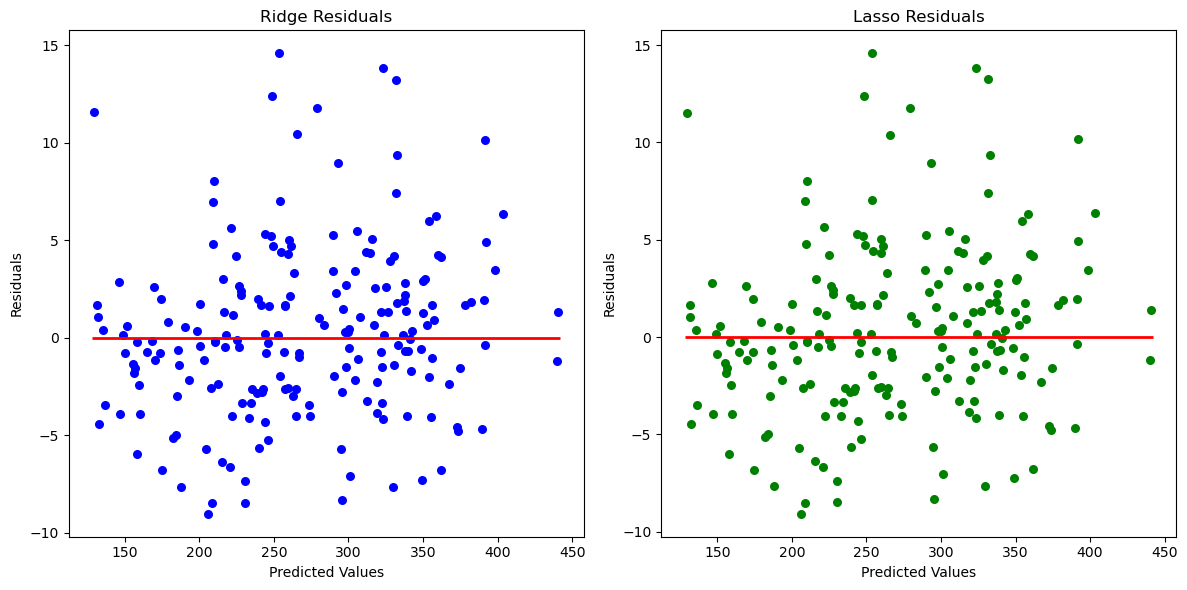

In [213]:
# Calculating residuals for both models
ridge_residuals = y_test - ridge_pred
lasso_residuals = y_test - lasso_pred

# Plotting residuals
plt.figure(figsize=(12, 6))

# Ridge residuals plot
plt.subplot(1, 2, 1)
plt.scatter(ridge_pred, ridge_residuals, color='blue', s=30)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), color='red', lw=2)
plt.title('Ridge Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Lasso residuals plot
plt.subplot(1, 2, 2)
plt.scatter(lasso_pred, lasso_residuals, color='green', s=30)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), color='red', lw=2)
plt.title('Lasso Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Adjust layout and show plot
plt.tight_layout()
plt.show()
